In [29]:
# Imports
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import find_peaks
from scipy.special import binom




In [30]:

BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_main_image = cv2.cvtColor(new_main_image, cv2.COLOR_BGR2RGB)
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image

def display_disp_image(to_be_displayed, title="Image", d_type="turbo"):
    plt.figure(figsize=(10, 6))
    plt.imshow(to_be_displayed, cmap=d_type)
    plt.title(title)
    plt.show()

def display_columns_on_image(input_image, col_indices=[500]):
    to_be_displayed = input_image.copy()
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = to_be_displayed.shape[0]
    width = to_be_displayed.shape[1]

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        to_be_displayed = cv2.line(to_be_displayed, (col_indices[index],0), (col_indices[index], height), colour, 3)
        #original_image = cv2.line(original_image, dimStart, dimSlutt, colour, 1)


    display_disp_image(to_be_displayed)


# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Båt =  1689068854381001093
# Fra blanda
KajakkOgBåt = 1689068879500907093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)

standard_fig_size = (10, 6)

all_disparity_images = [første_disparity, nærme_disparity, båt_disparity, kajakk_båt_disparity, båt_bak_disparity, båt_fram_disparity, badering_første_disparity, badering_mann_disparity]



Første: 1689072633388130541  Nærme:  1689072600363349541


In [31]:

def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        
        return column

    print("PERFORMED INTERPOLATION")
    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(input):
    dI = input.copy()
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])
    return dI

import matplotlib.colors as mcolors

def generate_dark_colors(n):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    
    return colors

def disparity_graphing(disp_map, col_indices=[500], display=False, invert=False):
    
    colours = ['red', 'green', 'blue']

    plt.figure(figsize=standard_fig_size)
    # Extract and plot each column


    for i, col in enumerate(col_indices):
            if(col > disp_map.shape[1]):
                col_indices.pop(i+1)

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]
        col_data = disp_map[:, col_idx]
        y_values = range(len(col_data))
        plt.plot(col_data, y_values, label=f'Column {index + 1} (Index {col_idx})', color=colour)


    title="Disparity profiles along Column(s) " + str(col_indices)

    # Invert y-axis to match image orientation
    if(invert):
        plt.gca().invert_yaxis()

    # Add labels and legend
    plt.xlabel('Disparity Value')
    plt.ylabel('V-value (rows)')
    plt.title(title)
    plt.legend()

    # Show the plot
    if(display):
        plt.show()

def display_columns_on_image(original_image, col_indices=[500]):
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = original_image.shape[0]
    width = original_image.shape[1]

    og_image = original_image.copy()

    for i, col in enumerate(col_indices):
            if(col > og_image.shape[1]):
                print("Cols popped")
                col_indices.pop(i+1)

    title="Columns on original image"


    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        og_image = cv2.line(og_image, (col_indices[index],0), (col_indices[index], height), colour, 3)


    display_disp_image(og_image)

def display_columns_on_image_V2(original_image, col_indices=[500], line_thickness=5, return_image=False):
    # Use a copy of the original image to draw on
    og_image = original_image.copy()
    height = og_image.shape[0]
    width = og_image.shape[1]

    title = "Columns on Original Image"

    # Half the thickness to apply on each side of the column
    half_thickness = line_thickness // 2

    # Iterate over each column index you want to display
    for col_idx in col_indices:
        if col_idx >= width:
            print("Column index out of image bounds:", col_idx)
            continue

        # Calculate the range to apply the thickness
        start_col = max(0, col_idx - half_thickness)
        end_col = min(width, col_idx + half_thickness + 1)

        # Iterate over each pixel in the specified column range
        for row in range(height):
            # Get the brightness of the main column pixel
            main_pixel = og_image[row, col_idx]
            main_brightness = 0.299 * main_pixel[0] + 0.587 * main_pixel[1] + 0.114 * main_pixel[2]

            # Choose the line color based on the main pixel brightness
            if main_brightness < 128:  # Dark pixel, make the line white
                line_color = (255, 255, 255)
            else:  # Light pixel, make the line black
                line_color = (0, 0, 0)

            # Apply this color to the surrounding pixels based on the thickness
            for adj_col in range(start_col, end_col):
                og_image[row, adj_col] = line_color

    # Display the modified image (assuming display_disp_image is a function you have for displaying/saving)
    display_disp_image(og_image, title=title)
    if(return_image):
        return og_image
    return


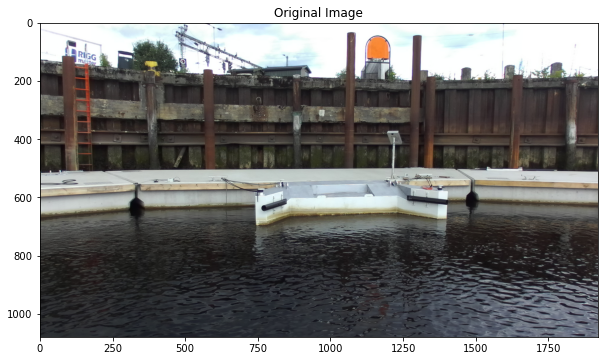

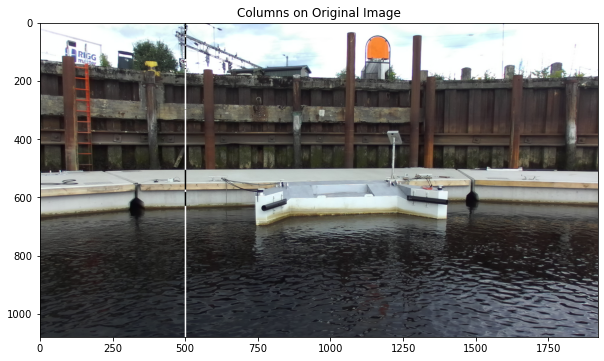

In [32]:
current_disparity_data = nærme_disparity.copy()
current_image = nærme_image.copy()
interpolate_each_column(current_disparity_data)
display_disp_image(current_image, "Original Image")
display_columns_on_image_V2(current_image,line_thickness=5)
#display_disp_image(current_disparity_data, "Interpolated Disparity Image")

In [33]:
plot_initial_images = False
testing_image = False

if(testing_image):
    # Testing image
    current_original_image = nærme_image
    current_disparity_data = nærme_disparity
    curr_col = [1250]
    display_columns_on_image(current_original_image, curr_col)
    display_columns_on_image_V2(current_original_image, curr_col)
    disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
 


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    display_columns_on_image(nærme_image, cols_nærme)
    display_columns_on_image_V2(nærme_image, cols_nærme)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)


    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    display_columns_on_image(første_image, cols_første)
    display_columns_on_image_V2(første_image, cols_første)
    disparity_graphing(første_disparity, cols_første, display=True, invert=False)
    disparity_graphing(første_disparity, cols_første, display=True, invert=True)


    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    display_columns_on_image(badering_første_image, cols_badering)
    display_columns_on_image_V2(badering_første_image, cols_badering)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)

    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    display_columns_on_image(badering_mann_image, cols_mann)
    display_columns_on_image_V2(badering_mann_image, cols_mann)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)

    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    display_columns_on_image(båt_image, cols_båt)
    display_columns_on_image_V2(båt_image, cols_båt)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)

    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
    display_columns_on_image_V2(kajakk_båt_image, cols_båtKajakk)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    
    
    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    display_columns_on_image(båt_bak_image, cols_båtBak)
    display_columns_on_image_V2(båt_bak_image, cols_båtBak)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)

    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    display_columns_on_image(båt_fram_image, cols_båtFram)
    display_columns_on_image_V2(båt_fram_image, cols_båtFram)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

#dI = nærme_disparity
#original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image



# Main pipeline

In [34]:
from scipy.special import binom

n = 30  # Length of the kernel
kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

# Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_binomial, padding=False):

    if(padding):
        # Padding function to repeat edge values
        def pad_with_edge_values(signal, pad_width):
            return np.pad(signal, pad_width, mode='edge')

        # Pad the signal with edge values
        pad_width = n // 2
        column = pad_with_edge_values(column, pad_width)
        filtered_column = np.convolve(column, K, mode='valid')
    # Apply convolution
    else:
        filtered_column = np.convolve(column, K, mode='same')
    return filtered_column

""" # Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_binomial):
    # Apply convolution
    filtered_column = np.convolve(column, K, mode='same')
    return filtered_column 
 """

def apply_low_pass_filter(dI, K=kernel_binomial):
    
    height, width = dI.shape
    df = np.zeros_like(dI)  # Low-pass filtered disparity image
    for x in range(width):
        df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial)

    return df


# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000, input_range=(-0.2,0.3)):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()

    if(plot):
        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_derivatives, bins=input_bins, range=input_range, color='blue', edgecolor='blue')
        plt.title(title)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return flattened_derivatives


def take_derivative_diff(df):
    print("Diff method")

    # Computing the derivative of each column
    df_derivative = np.diff(df, axis=0)

    # Padding to handle size difference after np.diff
    df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')

    return df_derivative



def take_derivative_sobel(df, normalize=True):
    print("Sobel method")  

    # Define the 1D Sobel kernelS
    kernel_m = np.array([1, 0, -1])

    # Initialize an array to store the vertical derivative image
    vertical_derivative = np.zeros_like(df)

    # Apply the Sobel kernel to each column
    if(normalize):
        for i in range(df.shape[1]):  # Iterate over columns
            vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2 
    else:
        for i in range(df.shape[1]):  # Iterate over columns
            vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same')

    return vertical_derivative


## Clustering
def clustering(flattened_derivatives, a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    clipped_derivatives = clipped_derivatives[(clipped_derivatives > a_mini) & (clipped_derivatives < a_maxi)]
    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init='auto')
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

def plot_clusters(clustering_model, labels):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]

    plt.figure()
    plt.hist(cluster1, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 1')
    plt.legend()
    plt.show()

    # Plot histogram 
    plt.figure()
    plt.hist(cluster2, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 2')
    plt.legend()
    plt.show()

    plt.figure()
    plt.hist(clustering_model, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of both clusters')
    plt.legend()
    plt.show()

# Gaussian fit function
def fit_gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev

def fit_clusters(clustering_model, labels):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]
    mean1, stddev1 = fit_gaussian(cluster1)
    mean2, stddev2 = fit_gaussian(cluster2)

    return mean1, mean2, stddev1, stddev2

def gaussian_curve(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)


def cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=1, plot=True):
    mean1, mean2, stddev1, stddev2 = fit_clusters(clustering_model, labels)
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev

    if(plot):
        # Create a range of x values
        x_values = np.linspace(-0.25, 0.45, 400)

        # Gaussian curves
        gaussian_curve1 = gaussian_curve(x_values, mean1, stddev1)
        gaussian_curve2 = gaussian_curve(x_values, mean2, stddev2)

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=400, range=(-0.25, 0.45), density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()
        
    return red_dL, red_dU, green_dL, green_dU


def thresholds_3_gaussians(flattened_derivatives, min_clip=-0.3, max_clip = 0.5, bins = 200, plot=True, k=2):
    num_curves = 3

    # Example flattened_derivatives - replace with your actual data
    # flattened_derivatives = ...

    # Clip the data between -0.3 and 0.6
    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)

    # Removing extreme values
    filtered_data = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]
    clipped_derivatives = filtered_data

    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    #gmm = GaussianMixture(n_components=2, random_state=0, init_params='kmeans++')

    gmm.fit(clipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()

    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)
        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))
            for i in range(2)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='g', label='Data Histogram')

        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')

        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()
    
    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]

    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'

    # Below are the upper and lower bounds
    # Assuming you have mean1, stddev1, mean2, stddev2 from the Gaussian fits


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev


    return red_dL, red_dU, green_dL, green_dU

def thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=2, plot=True, version=1):
    print("Thresholds Clipping verstion")

    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)
    clipped_derivatives = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]

    hist_values, bin_edges = np.histogram(clipped_derivatives, bins=num_bins, density=True)
    max_frequency = np.max(hist_values)
    threshold = p * max_frequency
    if(plot):
        print("Maximum frequency in the histogram:", max_frequency)
        print(f"Threshold ({p*100}% of max frequency):", threshold)

    # Adjust histogram values: set values below the threshold to 0
    smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)

    if(plot):
        # Plot the adjusted histogram
        plt.figure(figsize=(10, 6))
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers for plotting
        plt.bar(bin_centers, smooth_hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Smoothed Histogram')

        plt.legend()
        plt.title('Smoothed Histogram of Clipped Derivatives')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()

    # Find the indices of non-zero bins in the smoothed histogram 
    non_zero_indices = np.nonzero(smooth_hist_values)[0]

    # Extract the minimum and maximum value along the value axis
    min_value_range = bin_edges[non_zero_indices[0]]
    max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin

    reclipped_derivatives = clipped_derivatives[(clipped_derivatives > min_value_range) & (clipped_derivatives < max_value_range)]  

    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    gmm.fit(reclipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()
   
    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)

        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))
            for i in range(num_curves)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='g', label='Data Histogram')

        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')

        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()

    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]

    if(version==1):
        print("Returning thresholds")
        # Determine which mean is closer to 0 and assign labels
        if abs(mean1) < abs(mean2):
            red_mean, green_mean = mean1, mean2
            red_stddev, green_stddev = stddev1, stddev2
            red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
        else:
            red_mean, green_mean = mean2, mean1
            red_stddev, green_stddev = stddev2, stddev1
            red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


        red_dL = red_mean - k * red_stddev
        red_dU = red_mean + k * red_stddev
        green_dL = green_mean - k * green_stddev
        green_dU = green_mean + k * green_stddev

        return red_dL, red_dU, green_dL, green_dU
    else:
        print("Returning means and standard deviations")
        print("Mean1:", mean1,  "Stddev1:", stddev1)
        print("Mean2:", mean2, "Stddev2:", stddev2)
        return mean1, mean2, stddev1, stddev2 

# Dark color definitions with brightness < 128/256
Dark_Red = [100/256, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 100/256]  # Deep blue, similar to navy
Dark_Green = [0, 100/256, 0]  # Deep green
Bright_Red = [200/256, 0, 0]  # Bright red
Bright_Green = [0, 200/256, 0]  # Bright green
Bright_Blue = [0, 0, 200/256]  # Bright blue
Dark_Yellow = [128/256, 128/256, 0]  # Muted yellow, darkened
Dark_Purple = [75/256, 0, 130/256]  # Similar to indigo, dark purple
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/256, 139/256]  # Rich cyan, darkened
Dark_Magenta = [139/256, 0, 139/256]  # Deep magenta
Charcoal_Gray = [50/256, 50/256, 50/256]  # Dark gray, akin to charcoal
Dark_Lime = [50/256, 205/256, 50/256]  # A darker shade of lime green
Dark_Pink = [255/256, 20/256, 147/256]  # Deep pink, darkened
Dark_Olive = [85/256, 107/256, 47/256]  # Muted, darker olive green
Dark_Turquoise = [0, 206/256, 209/256]  # Deep turquoise
Dark_Brown = [165/256, 42/256, 42/256]  # A rich, dark brown
Dark_Goldenrod = [184/256, 134/256, 11/256] # Dark goldenrod
White = [1, 1, 1]  # White
Black = [0,0,0]
Dark_gray = [0.2,0.2,0.2]
Gray = [0.5,0.5,0.5]

colorScheme = {
    'horizontal1': Bright_Green,
    'horizontal2': Bright_Blue,
    'horizontal3': Dark_Green,
    'horizontal4': Dark_Brown,
    'horizontal5': Dark_Blue,
    'horizontal6': Charcoal_Gray,  # Custom darker teal
    'horizontal7': Dark_Lime,  # Custom dark leaf green
    'vertical1': Bright_Red,
    'vertical2': Dark_Magenta,
    'vertical3': Dark_Yellow,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': Gray,  
    'undecided': White,  # White
    'vertical': Bright_Red,
    'horizontal': Bright_Green
}


def gaussian_likelihood(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def compute_likelihood_ratio(x, mu1, mu2, sigma1, sigma2, only_return_ratio=True):
    P_x_gaussian1 = gaussian_likelihood(x, mu1, sigma1)
    P_x_gaussian2 = gaussian_likelihood(x, mu2, sigma2)
    L_x = P_x_gaussian1 / P_x_gaussian2

    if(only_return_ratio):
        return L_x
    return L_x, P_x_gaussian1, P_x_gaussian2

# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=2, include_undecided_label=True, likelihood_range=(0.5,2)):
    print("Classify and colour version 2")
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1

    print("Red mean:", red_mean, " Red stddev:", red_stddev)
    print("Green mean:", green_mean, " Green stddev:", green_stddev)
    
    print("K value:", k)
    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev
   
    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    #print("Undecided!!")
                    ratio, red_likelihood, green_likelihood  = compute_likelihood_ratio(derivative_value, red_mean, green_mean, red_stddev, green_stddev, False)
                    #print("Ratio: ", ratio)
                    if(likelihood_range[0] <= ratio <= likelihood_range[1]):
                        classification = 'undecided'
                    elif red_likelihood > green_likelihood:
                        classification = 'vertical' 
                    else:
                        classification = 'horizontal'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map



# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU, include_undecided_label=True):
    print("Classify and colour")

    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    print("UNDECIDED")
                    classification = 'undecided'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map
    
def assign_colours_and_plot(classification_map, colors=colorScheme, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()
    
    return color_coded_image





# Initial segmentation fullt kjør under:


In [35]:
def initial_segmentation(original_image, dI, clustering_bool=False, plot_figures=True):
    print("Initial segmentation")
    if(clustering_bool):
        k_value = 1
    else:
        k_value = 3
        curves = 4
        p_val = 0
        input_bins=200
    # Interpolate
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)


    # Take the derivative
    #df_derivative = take_derivative_diff(df)
    #df_derivative = take_derivative_sobel(df, normalize=False)
    #df_derivative = take_derivative_sobel(df)
    df_derivative = take_derivative_diff(df)

    # Flatten the derivatives for clustering
    flattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=False, title="Histogram of the derivatives")

    # Clustering method
    if(clustering_bool):
        print("Clustering method")
        clustering_model, clipped_derivatives, labels, centers = clustering(flattened_derivatives)
        if(plot_figures):
            plot_clusters(clustering_model, labels)
        red_dL,red_dU, green_dL, green_dU = cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=k_value, plot=plot_figures)
        classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)


    # Gaussian mixtures method
    else:
        print("Gaussian mixtures method")
        #red_dL, red_dU, green_dL, green_dU = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=2.5, plot=True)
        #classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)

        mean1, mean2, stddev1, stddev2 = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=curves, num_bins=input_bins,p=p_val, k=k_value, plot=plot_figures, version=2)
        classification_map = classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=k_value)


    # Original image
    if(plot_figures):
        display_disp_image(original_image, title="Original Image")

    # Plot colorized image
    colored_image = assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation", plot=plot_figures)

    if(plot_figures):
        display_disp_image(colored_image)

    return classification_map, colored_image, df_derivative

Initial segmentation
Diff method
Clustering method


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


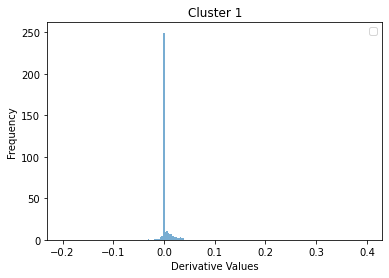

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


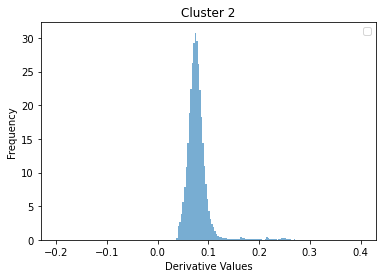

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


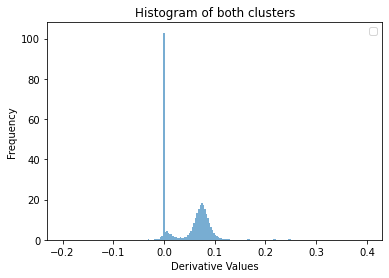

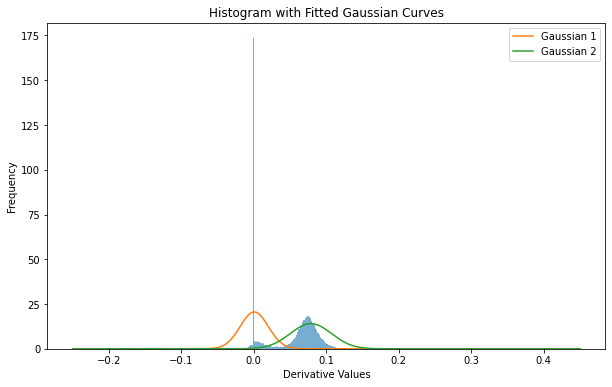

Classify and colour
includes undecided


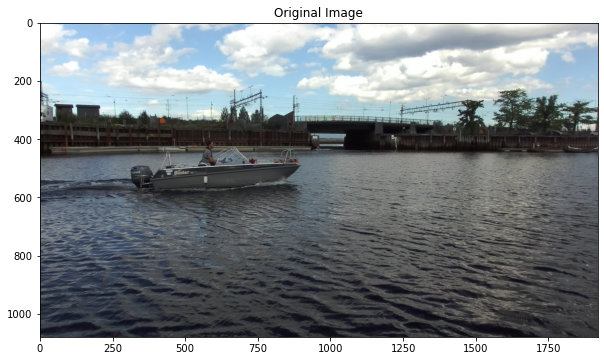

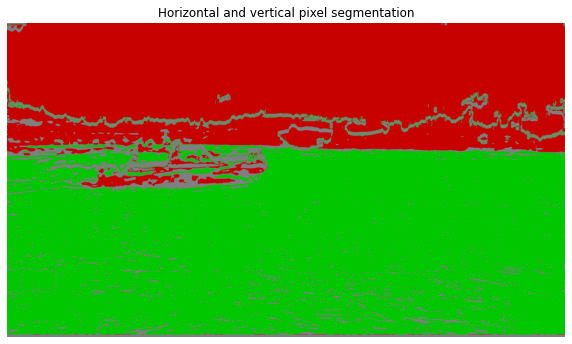

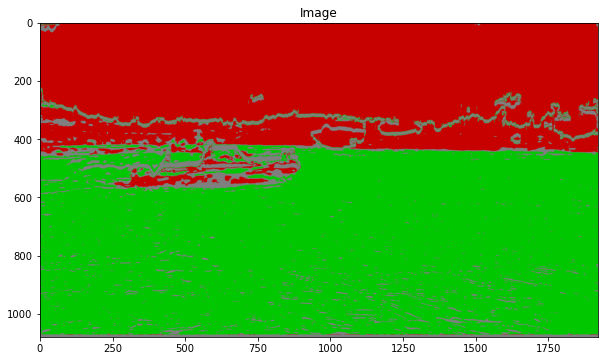

' clustering_bool = True\nif(clustering_bool):\n    k_value = 1\nelse:\n    k_value = 3\n    curves = 4\n    p_val = 0\n    input_bins=200\n# Interpolate\ndI = interpolate_each_column(dI)\n\n# Low-pass filter\ndf = apply_low_pass_filter(dI)\n\n\n# Take the derivative\n#df_derivative = take_derivative_diff(df)\n#df_derivative = take_derivative_sobel(df, normalize=False)\n#df_derivative = take_derivative_sobel(df)\ndf_derivative = take_derivative_diff(df)\n\n# Flatten the derivatives for clustering\nflattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=False, title="Histogram of the derivatives")\n\n# Clustering method\nif(clustering_bool):\n    print("Clustering method")\n    clustering_model, clipped_derivatives, labels, centers = clustering(flattened_derivatives)\n    plot_clusters(clustering_model, labels)\n    red_dL,red_dU, green_dL, green_dU = cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=k_value, plot=True)\n    classification_map = cl

In [36]:
dI = båt_disparity
original_image = båt_image

#dI = første_disparity
#original_image = første_image

#dI = nærme_disparity
#original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image


# ----------------------------------------------------------------------------
#Full method above
# ----------------------------------------------------------------------------

class_map, colored_image, _ = initial_segmentation(original_image, dI, clustering_bool=True, plot_figures=True)



""" clustering_bool = True
if(clustering_bool):
    k_value = 1
else:
    k_value = 3
    curves = 4
    p_val = 0
    input_bins=200
# Interpolate
dI = interpolate_each_column(dI)

# Low-pass filter
df = apply_low_pass_filter(dI)


# Take the derivative
#df_derivative = take_derivative_diff(df)
#df_derivative = take_derivative_sobel(df, normalize=False)
#df_derivative = take_derivative_sobel(df)
df_derivative = take_derivative_diff(df)

# Flatten the derivatives for clustering
flattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=False, title="Histogram of the derivatives")

# Clustering method
if(clustering_bool):
    print("Clustering method")
    clustering_model, clipped_derivatives, labels, centers = clustering(flattened_derivatives)
    plot_clusters(clustering_model, labels)
    red_dL,red_dU, green_dL, green_dU = cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=k_value, plot=True)
    classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)


# Gaussian mixtures method
else:
    print("Gaussian mixtures method")
    #red_dL, red_dU, green_dL, green_dU = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=2.5, plot=True)
    #classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)

    mean1, mean2, stddev1, stddev2 = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=curves, num_bins=input_bins,p=p_val, k=k_value, plot=True, version=2)
    classification_map = classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=k_value)


# Original image
display_disp_image(original_image, title="Original Image")

# Plot colorized image
colored_image = assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation")

display_disp_image(colored_image) """

# Visualization of kernels

In [37]:
plot_visualization_of_kernels= False
standard_n = 15

In [38]:
#column_index = disparity_map.shape[1] // 2
if(plot_visualization_of_kernels):
    disparity_map = første_disparity.copy()
    disparity_map = interpolate_each_column(disparity_map)
    column_index = 1140

    column_data_kernels = disparity_map[:, column_index]

    y_values = range(len(column_data_kernels))

    plt.figure(figsize=(10,6))
    plt.plot(column_data_kernels, y_values)
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('Disparity Values Along a Column')
    plt.show()
    
#all_disparity_images = [første_disparity, nærme_disparity, båt_disparity, kajakk_båt_disparity, båt_bak_disparity, båt_fram_disparity, badering_første_disparity, badering_mann_disparity]


""" for dI in all_disparity_images:

    print("New iteration")
    clustering = False
    k_value = 3

    # Interpolate
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)

    # Take the derivative
    #df_derivative = take_derivative_diff(df)
    #df_derivative = take_derivative_sobel(df, normalize=False)
    #df_derivative = take_derivative_sobel(df)
    df_derivative = take_derivative_diff(df)

    # Flatten the derivatives for clustering
    flatten_and_plot_histogram(df_derivative, plot=True, title="Histogram of the derivatives")
    flatten_and_plot_histogram(df_derivative, plot=True, title="Histogram of the derivatives", input_range=(-0.02,0.1))
 """

#Delbar
if(plot_visualization_of_kernels):
    n = standard_n
    n = 20  # Length of the kernel

    # Create a signal with a single one in the middle
    #signal = np.zeros(40)
    #signal[20] = 1
    signal = np.zeros(50)
    signal[25] = 1

    """ # Plotting binomial
    plt.figure(figsize=(10, 6))
    plt.plot(signal, label='Binomial Kernel Response', color='green')
    plt.title('Kernel Response Comparison')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.show() """


    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 


    # Apply the binomial kernel
    response_binomial = np.convolve(signal, kernel_binomial, mode='same')

    # Plotting binomial
    plt.figure(figsize=(10, 6))
    plt.plot(response_binomial, label='Binomial Kernel Response', color='green')
    plt.title('Kernel Response Comparison')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.show()


#Delbar
if(plot_visualization_of_kernels):
# Define the binomial kernel
#n = standard_n
    n = 20  # Length of the kernel

    m_mult = 3

    #signal = np.zeros(40)
    #signal[20] = 1
    signal = np.zeros(50)
    signal[25] = 1


    #
    # Create the Gaussian kernel
    sigma = n  # Standard deviation for the Gaussian kernel
    x = np.linspace(-m_mult*sigma, m_mult*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()

    # Apply the Gaussian kernel
    response_gaussian = np.convolve(signal, kernel_gaussian, mode='same')

    # Plotting the responses
    plt.figure(figsize=(10, 6))
    #plt.plot(response_binomial, label='Binomial Kernel Response', color='green')
    plt.plot(response_gaussian, label='Gaussian Kernel Response', color='blue')
    plt.title('Kernel Response Comparison')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.show()

if(plot_visualization_of_kernels):
# Define the binomial kernel
#n = standard_n
    n = 20  # Length of the kernel

    m_mult = 3

    #signal = np.zeros(40)
    #signal[20] = 1
    signal = np.zeros(50)
    signal[25] = 1


    #
    # Create the Gaussian kernel
    sigma = n  # Standard deviation for the Gaussian kernel
    x = np.linspace(-m_mult*sigma, m_mult*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()

    # Apply the Gaussian kernel
    response_gaussian = np.convolve(signal, kernel_gaussian, mode='same')

    # Plotting the responses
    plt.figure(figsize=(10, 6))
    #plt.plot(response_binomial, label='Binomial Kernel Response', color='green')
    plt.plot(response_gaussian, label='Gaussian Kernel Response', color='blue')
    plt.title('Kernel Response Comparison')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.show()

if(plot_visualization_of_kernels):
  # Length of the kernel
  #signal = np.zeros(40)
  #signal[20] = 1
  signal = np.zeros(50)
  signal[25] = 1

  #n = 15  # Size of the kernel, as Vipul used in his thesis 5
  n = standard_n
  kernel_k = np.ones(n) / n  # Kernel for averaging



  # Apply the rectangular kernel
  response_rectangular = np.convolve(signal, kernel_k, mode='same')

  # Apply the binomial kernel
  response_binomial = np.convolve(signal, kernel_binomial, mode='same')

  # Plotting Uniform
  plt.figure(figsize=(10, 6))
  plt.plot(response_rectangular, label='Rectangular Kernel Response', color='blue')
  plt.title('Kernel Response Comparison')
  plt.xlabel('Sample Number')
  plt.ylabel('Response')
  plt.legend()
  plt.show()

""" # Create a sample 1D signal
signal = np.sin(np.linspace(0, 2 * np.pi, 100)) + np.random.normal(0, 0.2, 100)

disparity_profile_første = column_data_kernels

# Define the uniform kernel
n = standard_n  # Size of the kernel
kernel_uniform = np.ones(n) / n

sigma = n  # Standard deviation for the Gaussian kernel
x = np.linspace(-3*sigma, 3*sigma, n)
kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
kernel_gaussian /= kernel_gaussian.sum()

kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

# Apply the uniform kernel to the signal using convolution
smoothed_signal = np.convolve(signal, kernel_uniform, mode='same')
smoothed_signal_disparity_profile_uniform = np.convolve(disparity_profile_første, kernel_uniform, mode='same')
smoothed_signal_disparity_profile_gaussian = np.convolve(disparity_profile_første, kernel_gaussian, mode='same')
smoothed_signal_disparity_profile_binomial = np.convolve(disparity_profile_første, kernel_binomial, mode='same')

print("Disp profile", len(disparity_profile_første))
print("Smoothed signal uniform", (smoothed_signal_disparity_profile_uniform))
print("Smoothed signal gaussian", (smoothed_signal_disparity_profile_gaussian))
print("Smoothed signal binomial", (smoothed_signal_disparity_profile_binomial))
 """


from scipy.special import binom


if(plot_visualization_of_kernels):

    # Create a sample 1D signal
    #signal = np.sin(np.linspace(0, 2 * np.pi, 100)) + np.random.normal(0, 0.2, 100)
    #disparity_profile_første = np.copy(signal)  # For demonstration, using the sample signal as disparity profile

    disparity_profile_første = column_data_kernels

    # Define the uniform kernel
    n = standard_n  # Size of the kernel
    n = 15
    kernel_uniform = np.ones(n) / n

    n=25
    # Define the Gaussian kernel
    sigma = n  # Standard deviation for the Gaussian kernel
    m = 5
    x = np.linspace(-m*sigma, m*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()

    n=20
    # Define the Binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)



    # Padding function to repeat edge values
    def pad_with_edge_values(signal, pad_width):
        return np.pad(signal, pad_width, mode='edge')

    def low_pass_convolve_single_profile(disparity_profile, kernel, n=5 ):
        print("Length of disparity profile:", len(disparity_profile))
        # Pad the signal with edge values
        pad_width = n // 2
        padded_disparity_profile = pad_with_edge_values(disparity_profile, pad_width)

        print("Length of padded disparity profile:", len(padded_disparity_profile))

        # Apply the kernels to the padded signal using convolution
        filtered_disparity_profile = np.convolve(padded_disparity_profile, kernel, mode='valid')

        print("Length of filtered disparity profile",len(filtered_disparity_profile))

        return filtered_disparity_profile


    print("Length of disparity profile:", len(disparity_profile_første))
    # Pad the signal with edge values
    pad_width = n // 2
    padded_disparity_profile = pad_with_edge_values(disparity_profile_første, pad_width)

    print("Length of padded disparity profile:", len(padded_disparity_profile))

    # Apply the kernels to the padded signal using convolution
    smoothed_signal_disparity_profile_uniform = np.convolve(padded_disparity_profile, kernel_uniform, mode='valid')
    smoothed_signal_disparity_profile_gaussian = np.convolve(padded_disparity_profile, kernel_gaussian, mode='valid')
    #smoothed_signal_disparity_profile_binomial = np.convolve(padded_disparity_profile, kernel_binomial, mode='valid')
    smoothed_signal_disparity_profile_binomial = low_pass_convolve_single_profile(disparity_profile_første, kernel_binomial, n=5)


    print("Length smoothed signal",len(smoothed_signal_disparity_profile_binomial))

    print("Disp profile", len(disparity_profile_første))
    print("Smoothed signal uniform", smoothed_signal_disparity_profile_uniform)
    print("Smoothed signal gaussian", smoothed_signal_disparity_profile_gaussian)
    print("Smoothed signal binomial", smoothed_signal_disparity_profile_binomial)

    # Plotting the original and smoothed signals
    plt.figure(figsize=(12, 6))
    plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_uniform, label='Smoothed Signal with Uniform Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_gaussian, label='Smoothed Signal with Gaussian Kernel', color='green', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_binomial, label='Smoothed Signal with Binomial Kernel', color='blue', alpha=0.7)
    plt.title('Effect of Different Kernels on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


if(plot_visualization_of_kernels):
    #y_values = range(len(smoothed_signal_disparity_profile_uniform[0:1078]))
    y_values = range(len(smoothed_signal_disparity_profile_uniform))

    print("Length of y_values", len(smoothed_signal_disparity_profile_uniform))


    # Plot the original and smoothed signals
    plt.figure(figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    #plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    #plt.plot(smoothed_signal_disparity_profile_uniform[0:1078], y_values, label='Smoothed Signal with Uniform Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_uniform, y_values, label='Smoothed Signal with Uniform Kernel', color='red', alpha=0.7)
    plt.title('Effect of Uniform Kernel on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    #y_values = range(len(smoothed_signal_disparity_profile_gaussian[0:1078]))
    y_values = range(len(smoothed_signal_disparity_profile_gaussian))



    # Plot the original and smoothed signals
    plt.figure(figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    #plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    #plt.plot(smoothed_signal_disparity_profile_gaussian[0:1078], y_values,  label='Smoothed Signal with gaussian Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_gaussian, y_values,  label='Smoothed Signal with gaussian Kernel', color='red', alpha=0.7)
    plt.title('Effect of gaussian Kernel on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


    #y_values = range(len(smoothed_signal_disparity_profile_binomial[0:1078]))
    y_values = range(len(smoothed_signal_disparity_profile_binomial))


    # Plot the original and smoothed signals
    plt.figure(figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    #plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    #plt.plot(smoothed_signal_disparity_profile_binomial[0:1078], y_values, label='Smoothed Signal with binomial Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_binomial, y_values, label='Smoothed Signal with binomial Kernel', color='red', alpha=0.7)
    plt.title('Effect of Binomial Kernel on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()




#### Derivatives


In [39]:
plot_derivatives = False

In [40]:


if(plot_derivatives):

    dI = første_disparity.copy()

    interpolate_each_column(dI)
    smoothen = True
    OG_df = dI.copy()
    if(smoothen):
        print("Low-pass filter")
        # This is manually doing the above cell
        # Apply the low-pass filter to each column
        height, width = dI.shape
        df = np.zeros_like(dI)  # Low-pass filtered disparity image
        gaussian_df = np.zeros_like(dI) 
        k_df = np.zeros_like(dI) 
        binomial_df = np.zeros_like(dI)
        for x in range(width):
            #df[:, x] = low_pass_filter(dI[:, x], K=kernel)
            gaussian_df[:, x] = low_pass_filter(dI[:, x], K=kernel_gaussian, padding=False)
            k_df[:, x] = low_pass_filter(dI[:, x], K=kernel_k, padding=False)
            binomial_df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial, padding=False)
        



    else:
        print("proceeds without smoothing the disparity data")

    df = binomial_df.copy()
    # Versjon 2 bruker np.diff 
    # Computing the derivative of each column
    df_derivative = np.diff(df, axis=0)

    # Padding to handle size difference after np.diff
    df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')
    #første_df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge') 

    # Versjon 2 bruker np.diff 
    # Computing the derivative of each column
    df_derivative_no_smoothing = np.diff(OG_df, axis=0)
    df_derivative_no_smoothing = np.pad(df_derivative_no_smoothing, ((0, 1), (0, 0)), mode='edge')

    df_derivative_gaussian = np.diff(gaussian_df, axis=0)
    df_derivative_gaussian = np.pad(df_derivative_gaussian, ((0, 1), (0, 0)), mode='edge')

    df_derivative_k = np.diff(k_df, axis=0)
    df_derivative_k = np.pad(df_derivative_k, ((0, 1), (0, 0)), mode='edge')

    df_derivative_binomial = np.diff(binomial_df, axis=0)
    df_derivative_binomial = np.pad(df_derivative_binomial, ((0, 1), (0, 0)), mode='edge')

    rang = 1070
    first = 10
    col = 1140
    plotting_OG = df_derivative_no_smoothing[first:rang, col]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(plotting_OG)
    plt.title('Derivative Values at Column Index ' +str(col) +' without low-pass filtering')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.grid(True)
    plt.show()

    plotting_gaussian = df_derivative_gaussian[first:rang, col]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(plotting_gaussian)
    plt.title('Derivative Values at Column Index ' +str(col) +' with gaussian low-pass filtering')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.grid(True)
    plt.show()

    plotting_k = df_derivative_k[first:rang, col]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(plotting_k)
    plt.title('Derivative Values at Column Index ' +str(col) +' with k-kernel low-pass filtering')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.grid(True)
    plt.show()








    print((df_derivative[:,col]))

    plot_data_12_04 = df_derivative_binomial[first:rang, col]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(plot_data_12_04)
    plt.title('Derivative Values at Column Index ' +str(col) +' with a binomial kernel low-pass filter')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.grid(True)
    plt.show()

    print(df_derivative_no_smoothing[:,col])



    plot_data_regular_12_04 = df[first:rang, col]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(plot_data_regular_12_04)
    plt.title('Derivative Values at Column Index ' +str(col) +'')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.grid(True)
    plt.show()




### Dividing the points into lists

In [41]:

def split_into_lists(surface_splitting_disparity_image, classification_map, df_derivative, get_columns=True, print_numbers=True):
    if(print_numbers):
        print("Splitting into lists")
        vertCount = 0
        horCount = 0
        noneCount = 0

    # Verticals
    vertical_Derivative_List = []
    vertical_Disp_List = []
    vertical_Obj_List = []

    divided_vertical_obj_list = []


    #Horizonals
    horizontal_Derivative_List = []
    horizontal_Disp_List = []
    horizontal_Obj_List = []

    divided_horizontal_obj_list = []

    if(get_columns):
        for j in range(classification_map.shape[1]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            for i in range(classification_map.shape[0]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    vertical_Derivative_List.append(df_derivative[i,j])
                    appendObjectVert = [surface_splitting_disparity_image[i, j], i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1
            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)

    else:
        for i in range(classification_map.shape[0]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            for j in range(classification_map.shape[1]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    vertical_Derivative_List.append(df_derivative[i,j])
                    appendObjectVert = [surface_splitting_disparity_image[i, j], i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1
            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)

    if(print_numbers):
        print("verticals: ", vertCount)
        print("Horizontals: ", horCount)
        print("Unknown: ", noneCount)
        print("[Disparity Value, Derivative Value, V index, U index, Label]")
    
    verticals = (vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list)
    horizontals =(horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list)

    return verticals, horizontals

def single_column_disparities(col_object_list, i):

    current_col = col_object_list[i]

    column_disparities = []
    for obj in current_col:
        disp = obj[0]
        column_disparities.append(disp)

    return column_disparities


def divided_vertical_disps(col_object_list):
    all_vertical_disps = []

    for col in range(len(col_object_list)):
        current_col = single_column_disparities(col_object_list, col)
        all_vertical_disps.append(current_col)

    return all_vertical_disps

def display_histogram(data, input_bins=200, input_range=(0,60)):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=input_bins,  range=input_range, alpha=0.6, label='Histogram', density=True)
    plt.title('Histogram of Disparity Values of Vertical labeled points')
    plt.xlabel('Disparity Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

from scipy.signal import find_peaks

def plot_histogram_with_peaks(data, bins=200, min_prominence=0.01, min_distance=1, auto_range=(-1,60), plot=True):

    # Ensure data is cleaned
    #data = np.array(data)
    #data = data[np.isfinite(data)]


    hist, bin_edges = np.histogram(data,range=auto_range, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(hist, prominence=min_prominence, distance=min_distance)

    if(plot):
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=bins,  range=auto_range, alpha=0.6, label='Histogram', density=True)
        plt.plot(bin_centers, hist, label='Histogram Line')
        plt.scatter(bin_centers[peaks], hist[peaks],color='red', s=100, zorder=5, label='Peaks/Modes')
        plt.title('Cluster Data and Detected Modes')
        plt.xlabel('Disparity')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    if(plot):
        print("Detected modes at:", peak_values)
    return peak_values


# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
perform = False

if(perform):
    surface_split_disparity_image = dI

    verticals, horizontals = split_into_lists(surface_split_disparity_image, class_map)

    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
    horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals


    print(len(vertical_Obj_List))
    print(len(horizontal_Obj_List))

    # i = column
    i = 730
    print("Horizontals: ", len(divided_horizontal_obj_list[i]))
    print("Verticals: ",len(divided_vertical_obj_list[i]))

    print("Disparity Value, Derivative Value, V index(row), U index)column), Label")
    print(divided_horizontal_obj_list[i][0])



    vert_col_disp_i = single_column_disparities(divided_vertical_obj_list, i)
    hor_col_disp_i = single_column_disparities(divided_horizontal_obj_list, i)


    all_vertical_disps = divided_vertical_disps(divided_vertical_obj_list)
    print("Length:  ", len(all_vertical_disps))
    print(all_vertical_disps[i])

    #for i in hor_col_disp_i:
    #    print(i)

In [42]:
""" num_bins = 200
number_of_peaks_vertical = []
all_peaks = []
min_dist = 1
for i in range(len(all_vertical_disps)):
    peaks = plot_histogram_with_peaks(all_vertical_disps[i], bins=num_bins, min_prominence=0.01, min_distance=min_dist,plot =False)
    number_of_peaks_vertical.append(len(peaks))
    for peak in peaks:
        all_peaks.append(peak)

    #print("Number of peaks: ",len(peaks))

    #display_histogram(all_vertical_disps[i], input_bins=num_bins)
 
#print(all_peaks)
display_histogram(all_peaks, input_bins=200)
 """


""" max_value = max(number_of_peaks_vertical)


print(max(number_of_peaks_vertical))

# Find the index of the maximum value
max_index = number_of_peaks_vertical.index(max_value)
print(max_index) """

""" #Båt: [585, 800] & 1689068854381001093 & Bridge-sequence \\

index = max_index
target_column = 1215
#target_column = 736

# Extract disparity (d) and row (v) values for the specific row
d_values = [obj[0] for obj in vertical_Obj_List if obj[2] == target_column]
v_values = [obj[1] for obj in vertical_Obj_List if obj[2] == target_column]
u_values = [obj[2] for obj in vertical_Obj_List if obj[2] == target_column]
#divided_vertical_obj_list

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_values,d_values, color='blue', marker='o')

# Labeling the plot
plt.xlabel('Row Value (v)')
plt.ylabel('Disparity Value (d)')
plt.title(f'Scatter Plot of vertical points at Column {target_column}')

# Display the plot
plt.show()

plot_histogram_with_peaks(all_vertical_disps[index], bins=num_bins, min_prominence=0.01, min_distance=min_dist)
display_histogram(all_vertical_disps[index], input_bins=num_bins) """

"""  
#column_index = disparity_map.shape[1] // 2

disparity_map = nærme_disparity.copy()
disparity_map = interpolate_each_column(disparity_map)
column_index = 500

column_data = disparity_map[:, column_index]

y_values = range(len(column_data))

plt.figure(figsize=(10,6))
plt.plot(column_data, y_values)
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
plt.xlabel('Disparity Value')
plt.ylabel('Image v-Axis')
plt.title('Disparity Values Along a Column')
plt.show()
"""

"  \n#column_index = disparity_map.shape[1] // 2\n\ndisparity_map = nærme_disparity.copy()\ndisparity_map = interpolate_each_column(disparity_map)\ncolumn_index = 500\n\ncolumn_data = disparity_map[:, column_index]\n\ny_values = range(len(column_data))\n\nplt.figure(figsize=(10,6))\nplt.plot(column_data, y_values)\nplt.gca().invert_yaxis()  # Invert y-axis to match image orientation\nplt.xlabel('Disparity Value')\nplt.ylabel('Image v-Axis')\nplt.title('Disparity Values Along a Column')\nplt.show()\n"

# Kladding for vertikal segmentering

Nærme kolonner: [730, 1215]


Første kolonner: [550, 1140] 


Badering [250, 1050] 


Mann kolonner: [620, 1100] 


Båt kolonner: [585, 800] 


Kajakk kolonner: [280, 1030] 


Båt bak kolonner: [1100, 1250] 


Båt fram kolonner: [500, 600] 


In [43]:
surface_split_disparity_image = båt_disparity.copy()
kladd_class_map, kladd_colored_image, splitting_derivative = initial_segmentation(båt_image, surface_split_disparity_image, clustering_bool=True, plot_figures=False)

flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")


#display_disp_image(kladd_colored_image)
# Båt : [585, 800]

Initial segmentation
Diff method
Clustering method


Classify and colour
includes undecided


In [44]:
current_column = 585

verticals, horizontals = split_into_lists(surface_split_disparity_image, class_map, splitting_derivative)

vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals


print(" Length vertical objects: ",len(vertical_Obj_List))
print(" Length horizontal objects",len(horizontal_Obj_List))


Splitting into lists
verticals:  785875
Horizontals:  1115636
Unknown:  172089
[Disparity Value, Derivative Value, V index, U index, Label]
 Length vertical objects:  785875
 Length horizontal objects 1115636


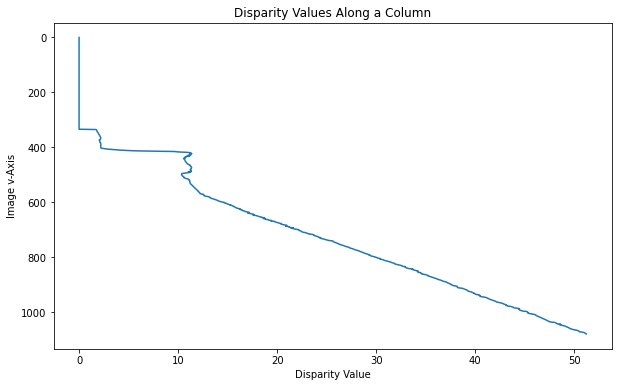

In [45]:
column_data = surface_split_disparity_image[:, current_column]

y_values = range(len(column_data))

plt.figure(figsize=(10,6))
plt.plot(column_data, y_values)
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
plt.xlabel('Disparity Value')
plt.ylabel('Image v-Axis')
plt.title('Disparity Values Along a Column')
plt.show()

## Plotting av histogrammer og Gaussian mixtures

Thresholds Clipping verstion
Maximum frequency in the histogram: 78.53966942020105
Threshold (1.0% of max frequency): 0.7853966942020105
Fitting regular
Fitting clipped
Fitting triple
Fitting four
Fitting reclipped
Fitting reclipped triple
Fitting reclipped four
Regular 2 curves


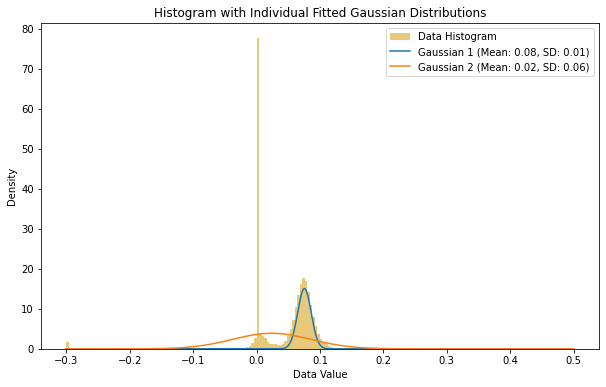

Clipped edges 2 curves


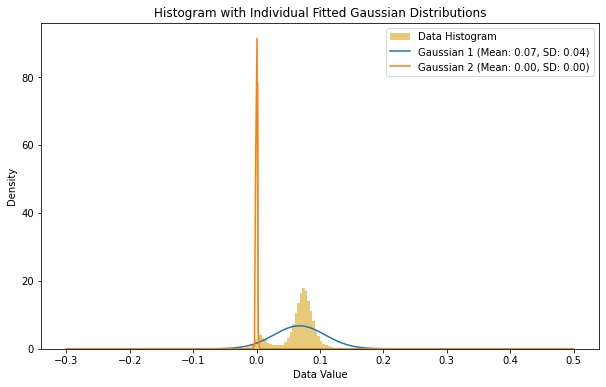

Clipped edges 3 curves


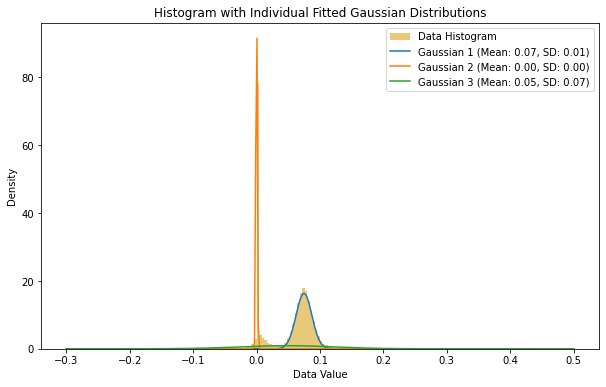

Clipped edges 4 curves


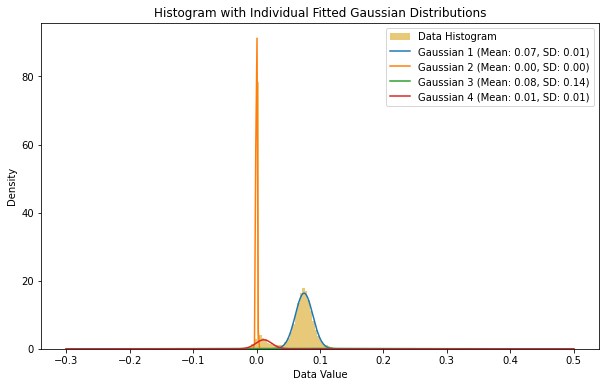

Reclipped 2 curves


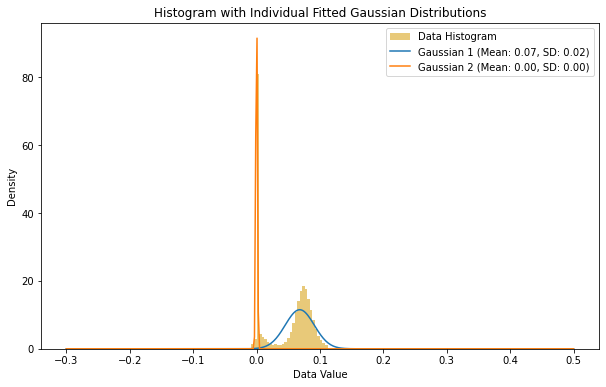

Reclipped 3 curves


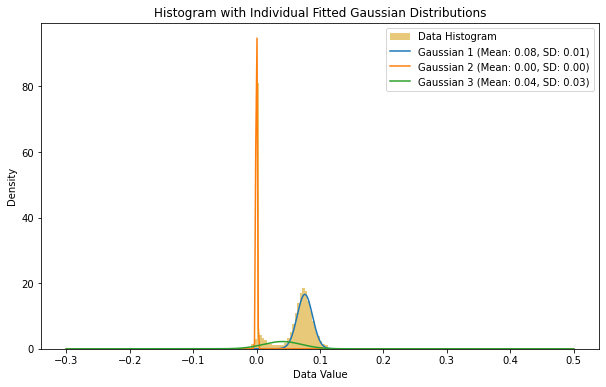

Reclipped 4 curves


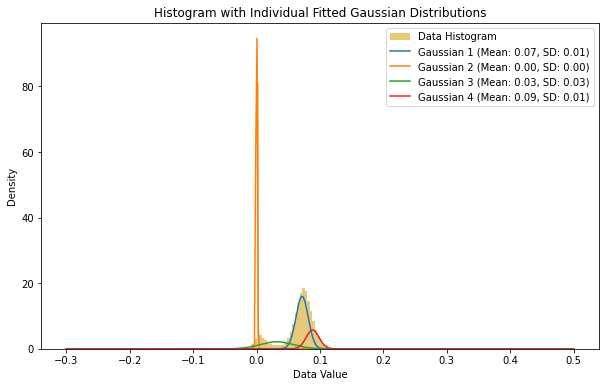

' \nmean1 = means[0]\nmean2 = means[1]\nstddev1 = std_devs[0]\nstddev2 = std_devs[1]\n\nif(version==1):\n    print("Returning thresholds")\n    # Determine which mean is closer to 0 and assign labels\n    if abs(mean1) < abs(mean2):\n        red_mean, green_mean = mean1, mean2\n        red_stddev, green_stddev = stddev1, stddev2\n        red_label, green_label = \'Cluster 1 (Red)\', \'Cluster 2 (Green)\'\n    else:\n        red_mean, green_mean = mean2, mean1\n        red_stddev, green_stddev = stddev2, stddev1\n        red_label, green_label = \'Cluster 2 (Red)\', \'Cluster 1 (Green)\'\n\n\n    red_dL = red_mean - k * red_stddev\n    red_dU = red_mean + k * red_stddev\n    green_dL = green_mean - k * green_stddev\n    green_dU = green_mean + k * green_stddev\n\n    #return red_dL, red_dU, green_dL, green_dU\nelse:\n    print("Returning means and standard deviations")\n    print("Mean1:", mean1,  "Stddev1:", stddev1)\n    print("Mean2:", mean2, "Stddev2:", stddev2)\n '

In [46]:
min_clip=-0.3    
max_clip=0.5
num_curves=2
num_bins=200
p=0.01
k=2
plot=True
version=1

print("Thresholds Clipping verstion")

regular_clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)
clipped_derivatives = regular_clipped_derivatives[(regular_clipped_derivatives > min_clip) & (regular_clipped_derivatives < max_clip)]

hist_values, bin_edges = np.histogram(clipped_derivatives, bins=num_bins, density=True)
max_frequency = np.max(hist_values)
threshold = p * max_frequency
if(plot):
    print("Maximum frequency in the histogram:", max_frequency)
    print(f"Threshold ({p*100}% of max frequency):", threshold)

# Adjust histogram values: set values below the threshold to 0
smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)

""" if(plot):
    # Plot the adjusted histogram
    plt.figure(figsize=(10, 6))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers for plotting
    plt.bar(bin_centers, smooth_hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Smoothed Histogram')

    plt.legend()
    plt.title('Smoothed Histogram of Clipped Derivatives')
    plt.xlabel('Data Value')
    plt.ylabel('Density')

    plt.show() """

# Find the indices of non-zero bins in the smoothed histogram 
non_zero_indices = np.nonzero(smooth_hist_values)[0]

# Extract the minimum and maximum value along the value axis
min_value_range = bin_edges[non_zero_indices[0]]
max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin

reclipped_derivatives = clipped_derivatives[(clipped_derivatives > min_value_range) & (clipped_derivatives < max_value_range)]  


##########################################
# Regular
##########################################
print("Fitting regular")
gmm_regular = GaussianMixture(n_components=2, random_state=0)
gmm_regular.fit(regular_clipped_derivatives.reshape(-1, 1))

means_regular = gmm_regular.means_.flatten()
covariances_regular = gmm_regular.covariances_.flatten()
weights_regular = gmm_regular.weights_.flatten()

##########################################
# Clipped
##########################################
print("Fitting clipped")
gmm_clipped = GaussianMixture(n_components=2, random_state=0)
gmm_clipped.fit(clipped_derivatives.reshape(-1, 1))

means_clipped = gmm_clipped.means_.flatten()
covariances_clipped = gmm_clipped.covariances_.flatten()
weights_clipped = gmm_clipped.weights_.flatten()


##########################################
# triple
##########################################
print("Fitting triple")
gmm_triple = GaussianMixture(n_components=3, random_state=0)
gmm_triple.fit(clipped_derivatives.reshape(-1, 1))

means_triple = gmm_triple.means_.flatten()
covariances_triple = gmm_triple.covariances_.flatten()
weights_triple = gmm_triple.weights_.flatten()

##########################################
# Four
##########################################
print("Fitting four")
gmm_four = GaussianMixture(n_components=4, random_state=0)
gmm_four.fit(clipped_derivatives.reshape(-1, 1))

means_four = gmm_four.means_.flatten()
covariances_four = gmm_four.covariances_.flatten()
weights_four = gmm_four.weights_.flatten()

##########################################
# Reclipped
##########################################
print("Fitting reclipped")
# Fit a Gaussian Mixture Model with 2 components to the data
gmm_reclipped = GaussianMixture(n_components=2, random_state=0)
gmm_reclipped.fit(reclipped_derivatives.reshape(-1, 1))

# Extract the means, covariances, and weights of the two Gaussians
means_reclipped = gmm_reclipped.means_.flatten()
covariances_reclipped = gmm_reclipped.covariances_.flatten()
weights_reclipped = gmm_reclipped.weights_.flatten()

##########################################
# Reclipped triple
##########################################
print("Fitting reclipped triple")
gmm_reclipped_triple = GaussianMixture(n_components=3, random_state=0)
gmm_reclipped_triple.fit(reclipped_derivatives.reshape(-1, 1))

means_reclipped_triple = gmm_reclipped_triple.means_.flatten()
covariances_reclipped_triple = gmm_reclipped_triple.covariances_.flatten()
weights_reclipped_triple = gmm_reclipped_triple.weights_.flatten()

##########################################
# Reclipped four
##########################################
print("Fitting reclipped four")
gmm_reclipped_four = GaussianMixture(n_components=4, random_state=0)
gmm_reclipped_four.fit(reclipped_derivatives.reshape(-1, 1))

means_reclipped_four = gmm_reclipped_four.means_.flatten()
covariances_reclipped_four = gmm_reclipped_four.covariances_.flatten()
weights_reclipped_four = gmm_reclipped_four.weights_.flatten()




# Create a range of x values for plotting
x_values = np.linspace(min_clip, max_clip, 400)




##########################################
#Regular
##########################################

print("Regular 2 curves")
gaussian_pdfs_regular = [
    weights_regular[i] * norm.pdf(x_values, means_regular[i], np.sqrt(covariances_regular[i]))
    for i in range(2)
]

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(regular_clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
for i, pdf in enumerate(gaussian_pdfs_regular):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_regular[i]:.2f}, SD: {np.sqrt(covariances_regular[i]):.2f})')
plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')
plt.show()

##########################################
# Clipped
##########################################

print("Clipped edges 2 curves")
gaussian_pdfs_clipped = [
    weights_clipped[i] * norm.pdf(x_values, means_clipped[i], np.sqrt(covariances_clipped[i]))
    for i in range(2)
]

plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
for i, pdf in enumerate(gaussian_pdfs_clipped):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_clipped[i]:.2f}, SD: {np.sqrt(covariances_clipped[i]):.2f})')
plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')
plt.show()

##########################################
# Triple
##########################################
print("Clipped edges 3 curves")
gaussian_pdfs_triple = [
    weights_triple[i] * norm.pdf(x_values, means_triple[i], np.sqrt(covariances_triple[i]))
    for i in range(3)
]

plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
for i, pdf in enumerate(gaussian_pdfs_triple):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_triple[i]:.2f}, SD: {np.sqrt(covariances_triple[i]):.2f})')
plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')
plt.show()

##########################################
# Four
##########################################
print("Clipped edges 4 curves")
gaussian_pdfs_four = [
    weights_four[i] * norm.pdf(x_values, means_four[i], np.sqrt(covariances_four[i]))
    for i in range(4)
]

plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
for i, pdf in enumerate(gaussian_pdfs_four):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_four[i]:.2f}, SD: {np.sqrt(covariances_four[i]):.2f})')
plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')
plt.show()


##########################################
# Reclipped
##########################################

print("Reclipped 2 curves")
# Calculate the individual Gaussians' PDFs
gaussian_pdfs_reclipped = [
    weights_reclipped[i] * norm.pdf(x_values, means_reclipped[i], np.sqrt(covariances_reclipped[i]))
    for i in range(2)
]

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
# Plot each Gaussian PDF
for i, pdf in enumerate(gaussian_pdfs_reclipped):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped[i]:.2f}, SD: {np.sqrt(covariances_reclipped[i]):.2f})')
plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')
plt.show()

##########################################
# Reclipped Triple
##########################################

print("Reclipped 3 curves")
# Calculate the individual Gaussians' PDFs
gaussian_pdfs_reclipped_triple = [
    weights_reclipped_triple[i] * norm.pdf(x_values, means_reclipped_triple[i], np.sqrt(covariances_reclipped_triple[i]))
    for i in range(3)
]

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
# Plot each Gaussian PDF
for i, pdf in enumerate(gaussian_pdfs_reclipped_triple):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped_triple[i]:.2f}, SD: {np.sqrt(covariances_reclipped_triple[i]):.2f})')
plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')
plt.show()

##########################################
# Reclipped Four
##########################################
print("Reclipped 4 curves")
# Calculate the individual Gaussians' PDFs
gaussian_pdfs_reclipped_four = [
    weights_reclipped_four[i] * norm.pdf(x_values, means_reclipped_four[i], np.sqrt(covariances_reclipped_four[i]))
    for i in range(4)
]

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
# Plot each Gaussian PDF
for i, pdf in enumerate(gaussian_pdfs_reclipped_four):
    plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped_four[i]:.2f}, SD: {np.sqrt(covariances_reclipped_four[i]):.2f})')
plt.legend()
plt.title('Histogram with Individual Fitted Gaussian Distributions')
plt.xlabel('Data Value')
plt.ylabel('Density')
plt.show()



""" 
mean1 = means[0]
mean2 = means[1]
stddev1 = std_devs[0]
stddev2 = std_devs[1]

if(version==1):
    print("Returning thresholds")
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev

    #return red_dL, red_dU, green_dL, green_dU
else:
    print("Returning means and standard deviations")
    print("Mean1:", mean1,  "Stddev1:", stddev1)
    print("Mean2:", mean2, "Stddev2:", stddev2)
 """

In [47]:
""" import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming 'flattened_derivatives' is your dataset
# flattened_derivatives = ...

# Step 1: Clip the data between -0.2 and 0.4
clipped_derivatives = np.clip(flattened_derivatives, -0.2, 0.4)

# Step 2: Fit a Gaussian Mixture Model with 2 components to the clipped data
gmm = GaussianMixture(n_components=4, random_state=0)
gmm.fit(clipped_derivatives.reshape(-1, 1))

# Step 3: Extract the means and standard deviations of the fitted Gaussians
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()

# Print the extracted parameters
print("Gaussian 1: Mean =", means[0], ", Standard Deviation =", std_devs[0])
print("Gaussian 2: Mean =", means[1], ", Standard Deviation =", std_devs[1])

# Optional: Plot the histogram of the clipped data and the fitted Gaussian PDFs
# Create a range of values for plotting the Gaussians
x_values = np.linspace(-0.1, 0.3, 400)
gmm_pdf = np.exp(gmm.score_samples(x_values.reshape(-1, 1)))

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=200, density=True, alpha=0.6, color='g', label='Data Histogram')

# Plot the overall PDF of the two Gaussians
plt.plot(x_values, gmm_pdf, label='Fitted Gaussians', color='red')
plt.legend()
plt.title('Histogram with Fitted Gaussian Distributions on Clipped Data')
plt.xlabel('Data Value')
plt.ylabel('Density')

plt.show()


  """

' import numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.mixture import GaussianMixture\n\n# Assuming \'flattened_derivatives\' is your dataset\n# flattened_derivatives = ...\n\n# Step 1: Clip the data between -0.2 and 0.4\nclipped_derivatives = np.clip(flattened_derivatives, -0.2, 0.4)\n\n# Step 2: Fit a Gaussian Mixture Model with 2 components to the clipped data\ngmm = GaussianMixture(n_components=4, random_state=0)\ngmm.fit(clipped_derivatives.reshape(-1, 1))\n\n# Step 3: Extract the means and standard deviations of the fitted Gaussians\nmeans = gmm.means_.flatten()\nstd_devs = np.sqrt(gmm.covariances_).flatten()\n\n# Print the extracted parameters\nprint("Gaussian 1: Mean =", means[0], ", Standard Deviation =", std_devs[0])\nprint("Gaussian 2: Mean =", means[1], ", Standard Deviation =", std_devs[1])\n\n# Optional: Plot the histogram of the clipped data and the fitted Gaussian PDFs\n# Create a range of values for plotting the Gaussians\nx_values = np.linspace(-0.1, 0.3,